# Migrating from MSE regression

This notebook compares mean-squared error (MSE) regression to quantile regression in order to exemplify the changes that are required to solve a regression task using a QRNN istead of MSE regression.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import quantnn
import quantnn.plotting
quantnn.plotting.set_style()


Bad key "mathtext.fallback" on line 203 in
/home/simonpf/src/quantnn/quantnn/data/matplotlib_style.rc.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


As example problem we consider the same probabilistic function as in the [simple example](./simple_example.ipynb) notebook.

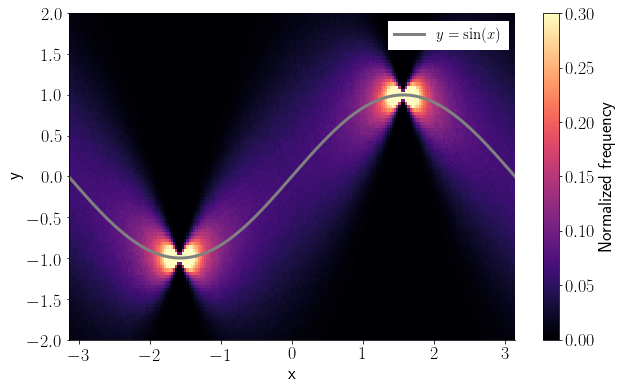

In [2]:
from quantnn.examples import simple
x, y = simple.create_training_data(10_000_000)
simple.plot_histogram(x, y)

## MSE regression

We will use PyTorch to solve the regression problem $y = f(x)$. We start by creating a fully-connected neural network with four layers, 128 neurons in each layer and ReLU activation functions.

In [3]:
import torch
from torch import nn

n_neurons = 128
n_layers = 5
activation = nn.ReLU

layers = [nn.Linear(1, n_neurons),
          activation()]
layers += [nn.Linear(n_neurons, n_neurons),
           activation()] * n_layers
layers += [nn.Linear(n_neurons, 1)]
mse_nn = nn.Sequential(*layers)

### Preparing the data

We prepare the training data by wrapping it into data loaders, which will generate batches of training samples.

In [4]:
from torch.utils.data import DataLoader, TensorDataset
x_tensor = torch.tensor(x[::10].reshape(-1, 1)).float()
y_tensor = torch.tensor(y[::10].reshape(-1, 1)).float()
training_data = TensorDataset(x_tensor, y_tensor)
training_loader = DataLoader(training_data, batch_size=512, shuffle=True)

### Training

As is common in PyTorch, we write a generic training loop to drive the actual training.

In [6]:
def train_network(model,
                  training_data,
                  loss,
                  optimizer,
                  n_epochs,
                  scheduler=None):
    """
    The standard training loop. For the given number of epochs, this
    functions loops over batches in the given training data, calculates
    the loss and updates training parameters and scheduler.
    
    Args:
        model(torch.nn.Module): The neural network model to train.
        training_data(Iterable): Iterable providing access to batches in training data.
        loss: The loss function to minimize.
        optimizer: PyTorch optimizer object to use to traing the network.
        scheduler: Learning rate scheduler object.
        n_epochs: The number of epochs for which to train the network.
    """
    model.train()
    
    for i in range(n_epochs):
        epoch_loss = 0
        for j, (x, y) in enumerate(training_data):
            
            # Clear gradients.
            optimizer.zero_grad()
            
            # Forward propagate input.
            y_pred = model(x)
            
            # Ensure output is of right size.
            batch_size = x.shape[0]
            y_pred = y_pred.reshape(batch_size, -1)
            y = y.reshape(batch_size, -1)
            l = loss(y_pred, y)
            
            # Calculate gradients
            l.backward()
            
            # Update parameters and LR scheduler.
            optimizer.step()
            if scheduler:
                scheduler.step()
            
            epoch_loss += l.item()
            print(f"Epoch {i:2}: Batch loss = {l.item():6.3}", end="\r")
        print(f"Epoch {i:2}: Avg. loss = {epoch_loss / j:6.3}", end="\n")
    model.eval()

Finally, we put everything together and train the network using the mean squared error loss function. We run the training for 16 epochs and gradually decrease the learning rate.

In [7]:
from torch.optim import SGD

loss = nn.MSELoss()

# Training with lr = 0.1
optimizer = SGD(mse_nn.parameters(), lr=0.1)
train_network(mse_nn, training_loader, loss, optimizer, 8)

# Training with lr = 0.01
optimizer = SGD(mse_nn.parameters(), lr=0.01)
train_network(mse_nn, training_loader, loss, optimizer, 4)

# Training with lr = 0.001
optimizer = SGD(mse_nn.parameters(), lr=0.001)
train_network(mse_nn, training_loader, loss, optimizer, 4)

Epoch  0: Avg. loss =  0.5169
Epoch  1: Avg. loss =  0.5058
Epoch  2: Avg. loss =  0.5047
Epoch  3: Avg. loss =  0.5048
Epoch  4: Avg. loss =  0.5034
Epoch  5: Avg. loss =  0.5035
Epoch  6: Avg. loss =  0.5034
Epoch  7: Avg. loss =  0.5035
Epoch  0: Avg. loss =  0.5028
Epoch  1: Avg. loss =  0.5016
Epoch  2: Avg. loss =  0.5018
Epoch  3: Avg. loss =  0.5026
Epoch  0: Avg. loss =  0.5014
Epoch  1: Avg. loss =  0.5012
Epoch  2: Avg. loss =  0.5019
Epoch  3: Avg. loss =  0.5019


## Quantile regression (the manual way)

Compared to train a MSE regression network on the data, training a QRNN requires only the following additional steps or modifications:
1. Specify the quantiles to predict.
2. Extending the number of outputs of the network to the number of quantiles.
3. Train the neural network using the means of the quantile loss function
\begin{align}
    \mathcal{L}_\tau(y_\tau, y) &= \begin{cases}
    \tau (y - y_\tau) & \text{if } y_\tau \leq y \\
    (1 - \tau) (y_\tau - y) &\text{otherwise} \\
    \end{cases}
\end{align}

To train the network to predict multiple quantiles of the posterior distribution $P(y|x)$, we simply average the loss functions for all quantiles $y_\tau$ we chose to predict.

### Defining the neural network model

We start be defining the quantiles to predict and the architecture of the QRNN model. The only change we need to make to the model architecture is the number of outputs, which should be equal to the number of quantiles we aim to predict.

In [8]:
quantiles = [0.01, 0.05, 0.15, 0.25, 0.35, 0.45, 0.5, 0.55, 0.65, 0.75, 0.85, 0.95, 0.99]

In [9]:
layers = [nn.Linear(1, n_neurons),
          activation()]
layers += [nn.Linear(n_neurons, n_neurons),
           activation()] * n_layers
layers += [nn.Linear(n_neurons, len(quantiles))]
qrnn = nn.Sequential(*layers)

### The quantile loss

The ``quantile_loss`` function implements a generic tensor version of the quantile loss function. Generic here means that is works not only for PyTorch tensors but also for numpy array, Tensorflow tensors and a few other types. We use it here to define a custom ``QuantileLoss`` class, which can be used in the training routine defined above. To reduce the results to a scalar value, we average over that batch and quantile dimensions.

In [10]:
import quantnn as q
class QuantileLoss:
    def __init__(self, quantiles):
        self.quantiles = quantiles
        
    def __call__(self, y_pred, y_true):
        return q.quantile_loss(y_pred, self.quantiles, y_true).mean()

In [11]:
from torch.optim import SGD

loss = QuantileLoss(quantiles)

# Training with lr = 0.1
optimizer = SGD(qrnn.parameters(), lr=0.1)
train_network(qrnn, training_loader, loss, optimizer, 8)

# Training with lr = 0.01
optimizer = SGD(qrnn.parameters(), lr=0.01)
train_network(qrnn, training_loader, loss, optimizer, 4)

# Training with lr = 0.001
optimizer = SGD(qrnn.parameters(), lr=0.001)
train_network(qrnn, training_loader, loss, optimizer, 4)

Epoch  0: Avg. loss =  0.1972
Epoch  1: Avg. loss =  0.1656
Epoch  2: Avg. loss =  0.1634
Epoch  3: Avg. loss =  0.1628
Epoch  4: Avg. loss =  0.1624
Epoch  5: Avg. loss =  0.1623
Epoch  6: Avg. loss =  0.1626
Epoch  7: Avg. loss =  0.1621
Epoch  0: Avg. loss =  0.1628
Epoch  1: Avg. loss =  0.1627
Epoch  2: Avg. loss =  0.1621
Epoch  3: Avg. loss =  0.1622
Epoch  0: Avg. loss =  0.1623
Epoch  1: Avg. loss =  0.1629
Epoch  2: Avg. loss =  0.1625
Epoch  3: Avg. loss =  0.1621


## Quantile regression (the easy way)

The section above described how to train a QRNN in PyTorch from scratch in order to illustrate how simple it is to use custom network architecture for quantile regression. To reduce the amount of required boiler plate code to train a neural network, the quantnn package provides the ``QRNN`` class. This class implements generic training functions to train and evaluate QRNNs.


### Using a fully-connected architecture

To train a fully-connected neural network with the ``QRNN`` class you can simply pass a tuple ``(n_layers, n_neurons, activation)`` describing the architecture of the network. 

In [15]:
quantnn.set_default_backend("pytorch")
qrnn = quantnn.QRNN(quantiles,
                    n_inputs=1,
                    model=(n_layers, n_neurons, "relu"))

In [14]:
errors = qrnn.train(training_loader,
                    n_epochs=10)

Epoch  1 / 10: train. loss = 0.1654, lr. = 0.0010, time = 10.42122 s
Epoch  2 / 10: train. loss = 0.0812, lr. = 0.0010, time = 10.729159 s
Epoch  3 / 10: train. loss = 0.0541, lr. = 0.0010, time = 10.86849 s
Epoch  4 / 10: train. loss = 0.0405, lr. = 0.0010, time = 10.86345 s
Epoch  5 / 10: train. loss = 0.0324, lr. = 0.0010, time = 10.892609 s
Epoch  6 / 10: train. loss = 0.0270, lr. = 0.0010, time = 10.912857 s
Epoch  7 / 10: train. loss = 0.0231, lr. = 0.0010, time = 10.983728 s
Epoch  8 / 10: train. loss = 0.0202, lr. = 0.0010, time = 10.929585 s
Epoch  9 / 10: train. loss = 0.0180, lr. = 0.0010, time = 10.945933 s
Epoch 10 / 10: train. loss = 0.0162, lr. = 0.0010, time = 10.957991 s


### Using a custom model

Instead of an architecture-tuple, it is also possible to provide a custom neural network model directly.

In [16]:
import quantnn

In [33]:
n_neurons = 128
n_layers = 5
activation = nn.ReLU

layers = [nn.Linear(1, n_neurons),
          activation()]
layers += [nn.Linear(n_neurons, n_neurons),
           activation()] * n_layers
layers += [nn.Linear(n_neurons, len(quantiles))]
model = nn.Sequential(*layers)

qrnn = quantnn.QRNN(n_inputs=1,
                    model=model,
                    quantiles=quantiles)

In [34]:
errors = qrnn.train(training_loader,
                    n_epochs=10)

Epoch  1 / 10: train. loss = 0.1666, lr. = 0.0010, time = 9.035305 s
Epoch  2 / 10: train. loss = 0.0812, lr. = 0.0010, time = 9.019712 s
Epoch  3 / 10: train. loss = 0.0541, lr. = 0.0010, time = 9.025991 s
Epoch  4 / 10: train. loss = 0.0406, lr. = 0.0010, time = 9.104716 s
Epoch  5 / 10: train. loss = 0.0324, lr. = 0.0010, time = 9.070726 s
Epoch  6 / 10: train. loss = 0.0270, lr. = 0.0010, time = 9.096888 s
Epoch  7 / 10: train. loss = 0.0231, lr. = 0.0010, time = 9.122733 s
Epoch  8 / 10: train. loss = 0.0202, lr. = 0.0010, time = 9.14773 s
Epoch  9 / 10: train. loss = 0.0180, lr. = 0.0010, time = 9.157791 s
Epoch 10 / 10: train. loss = 0.0162, lr. = 0.0010, time = 9.172499 s


## Evaluating the model

Finally, we evaluate the two models on newly generated validation data. The plot belows shows the distribution of the training data and overlaid the predicted y values obtained using MSE regression and using quantiles regression. While MSE regression is only able to predict the mean of the fuction, the QRNN is able to give a mostly accurate prediction the full distribution of $y$ values and how it varies with respect to $x$.

> **Note**: The QRNN predictions are obviously not perfect can be further

In [35]:
n = 1_0000
x_val = np.linspace(-np.pi, np.pi, n)
y_val = simple.create_validation_data(x_val)

In [36]:
x_tensor = torch.tensor(x_val.reshape(-1, 1)).float()
y_pred_mse = mse_nn(x_tensor).detach().numpy()
y_pred_qrnn = qrnn.predict(x_tensor).detach().numpy()

In [38]:
x_bins = np.linspace(-np.pi, np.pi, 201)
y_bins = np.linspace(-2, 2, 201)
img, _, _ = np.histogram2d(x, y, bins=(x_bins, y_bins), density=True)
x_centers = 0.5 * (x_bins[1:] + x_bins[:-1])
y_centers = 0.5 * (y_bins[1:] + y_bins[:-1])

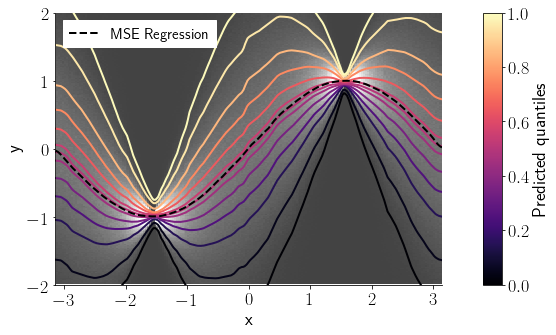

In [41]:
from matplotlib.gridspec import GridSpec
from matplotlib.cm import magma, ScalarMappable
from matplotlib.colors import Normalize
plt.figure(figsize=(8, 5))
gs = GridSpec(1, 2, width_ratios=[1.0, 0.05])
ax = plt.subplot(gs[0])

ax.pcolormesh(x_centers, y_centers, img.T, vmin=-0.08, vmax=0.3, cmap="Greys_r")
for i, q in enumerate(quantiles):
    ax.plot(x_val, y_pred_qrnn[:, i], c=magma(q))
ax.plot(x_val, y_pred_mse, "k", label="MSE Regression", ls="--")
    
ax.set_xlim([-np.pi, np.pi])
ax.set_ylim([-2, 2])
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()

#
# Add the colorbar.
#

cax = plt.subplot(gs[1])
sm = ScalarMappable(cmap=magma, norm=Normalize(0, 1))
sm.set_array(quantiles)
plt.colorbar(sm, cax=cax, label="Predicted quantiles")